# Part 2: Scale-space blob construction
The goal of Part 2 of the assignment is to build a blob coordinate system as discussed in lecture (and slides, and notes!).

### Algorithm outline
1. Find corners using a Harris corner detector. You may use a library based corner detector if you wish, though reading the manual will likely take as long as building your own.
2. For each corner:
    - At each corner location, apply a set of scale normalized Laplacian of Gaussian filters at several different scales.
    - Find the scale that gives the maximum absolute value response from the LOG filter, using non-linear interpolation between scale values.
    - Within the window defined by that scale, compute the most common orientation.
    - Mark on the image:
        1. The location of the corner, with an x
        2. The scale of the LOG at the corner, with a circle whose radius is the scale and whose center is the corner.
        3. The orientation of the window, with an arrow pointing from the corner in the direction of the orientation.

In [1718]:
# import data
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy import signal
import skimage as ski

In [1719]:
step = 0.8
def display_corners(image, coords, title="Corners detected"):
 plt.imshow(image, cmap='gray')
 plt.title(title)
 plt.plot(coords[:, 1], coords[:, 0], 'o', markersize=1, c='r')

def gaussian_pyramid(img, n=15):
    out = []
    out.append(img)
    for i in range(n):
        img = ski.transform.resize(img, (int(img.shape[0]*step), int(img.shape[1]*step)), preserve_range=True)
        out.append(img)
        # plt.figure()
        # plt.imshow(img)
    return out

def LOG(pyramid, x, y):
    out = []
    sigma = 2
    k=1
    win_size = sigma*6
    w_half=win_size//2
    for img in pyramid:
        x= int(x*step)
        y= int(y*step)
        if x-w_half>=0 and y-w_half>=0 and x+w_half+1<img.shape[0] and y+w_half+1<img.shape[1]:
            input = img[x-w_half:x+w_half+1,y-w_half:y+w_half+1]
            log = ndimage.gaussian_laplace(input, sigma) * ((k*sigma)**2)
            max_val = max(abs(log.max()), abs(log.min()))
            # max_val = abs(log.min())
            out.append([k,max_val])
            # print(max_val)
        k = k/step
    return out
 

In [1720]:
def show_all_arrows(title, image, cx, cy, rad, ori, color='b'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyArrow,Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y,r, ori in zip(cx, cy,rad, ori):
        dy = r * np.cos(ori)
        dx = r * np.sin(ori)
        circ = Circle((x, y), r, color='r', fill=False)
        ax.add_patch(circ)
        arr = FancyArrow(x, y, dx, dy, head_width=3, color=color, fill=False)
        ax.add_patch(arr)

    plt.title(title)
    plt.plot(cx, cy, 'x', markersize=5, c='r')
    # plt.savefig("test/{}.png".format(title))
    plt.show()

In [1721]:
def orientation(x, y, scale, ix, iy):
    import math
    from random import random
    window_size = int(scale*12)
    w_half = int(window_size//2)
    # print(window_size, w_half)
    max_hist = -math.inf
    max_mag = -math.inf
    max_idx=0
    orient=0
    for i in range(x-w_half, x+w_half+1):
        for j in range(y-w_half, y+w_half+1):
            if i>=0 and j>=0 and i<ix.shape[0] and j<iy.shape[1]:
                magnitude = np.sqrt(ix[i][j]**2 + iy[i][j]**2)
                if magnitude>max_mag:
                    max_mag=magnitude
                    ar = np.arctan2(iy[i][j], ix[i][j])
                    # print(ar)
                    if ar <0: 
                        orient = ar+2*np.pi
                    else:
                        orient = ar

    return orient

In [1722]:
#  try to use histogram
    # i_start = max(x-w_half, 0)
    # i_end = min(x+w_half+1, ix.shape[0])
    # j_start = max(y-w_half, 0)
    # j_end = min(y+w_half+1, ix.shape[1])
    # # print(i_start,i_end,j_start,j_end)
    # # print(x,y)
    # orient = np.arctan2(iy[i_start:i_end,j_start:j_end], ix[i_start:i_end,j_start:j_end])
    # orient[orient<0] += 2*np.pi
    # magnitude = np.sqrt(iy[i_start:i_end,j_start:j_end]**2 + ix[i_start:i_end,j_start:j_end]**2)
    # # plt.figure()
    # # plt.imshow(magnitude)

    # hist, bin_edges = np.histogram(orient)
    # for i, num in enumerate(hist):
    #     if num > max_hist:
    #         max_hist=num
    #         max_idx = i
    #     elif num == max_hist and random()<0.5:
    #         max_idx = i
    #         print("same")
    # plt.figure()
    # plt.plot(hist)
    # print(bin_edges)

    # print(orient.shape)
    # return bin_edges[max_idx]

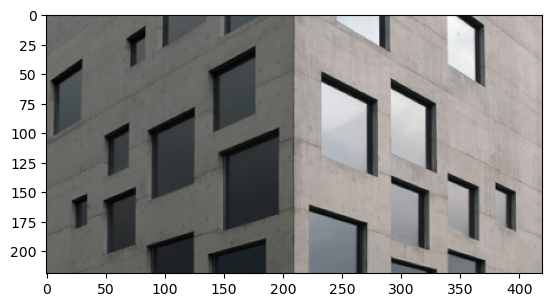

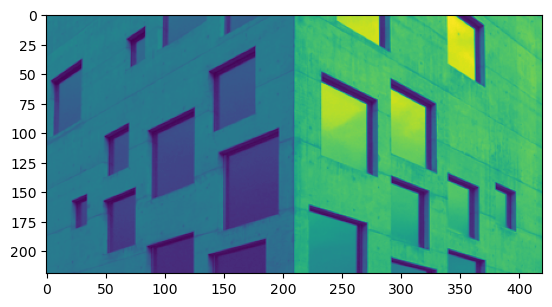

In [1741]:
# name = "p2_4" 
name = "p2_1" 
# name = "p2_5" 
name = "p2_4" 
# name = "p2_2" 

action = "base"

im=Image.open("data_p2/{}.jpg".format(name)) 
im = im.resize([int(im.size[0]/4),int(im.size[1]/4)])

# action = "90_clockwise"
# im = im.rotate(-90, expand=True)

# action = "90_counterclockwise"
# im = im.rotate(90, expand=True)

# action = "shift_left"
# sh = im.size[0]*0.2
# im = im.rotate(0,translate=[-sh,0], expand=True)
# box = (0,0, im.size[0]-sh,im.size[1])
# im = im.crop(box)

# action = "shift_right"
# sh = im.size[0]*0.2
# im = im.rotate(0,translate=[sh,0], expand=True)
# box = (sh,0, im.size[0],im.size[1])
# im = im.crop(box)

# action = "scale"
# box = (im.size[0]/2,im.size[1]/2, im.size[0]/2 + im.size[0],im.size[1]/2+im.size[1])
# im= im.resize([int(im.size[0]*2),int(im.size[1]*2)])
# im = im.crop(box)

plt.figure()
plt.imshow(im)

# convert to grayscale, rescale intensities to [0,1]
gray = np.asarray(im.convert('L'))
gray = gray/255.0
# print(gray)
plt.figure()
plt.imshow(gray)

In [1742]:
# compute partial derivatives ix, iy at each pixel
ix = ndimage.sobel(gray,0)
iy = ndimage.sobel(gray,1)


In [1743]:
# Harris corner detector

# sigma = 1
# w_size = max(7, int(sigma*6))
# wx = np.matrix(signal.windows.gaussian(w_size, sigma))
# wy = np.matrix(signal.windows.gaussian(w_size, sigma))
# w = wx.T*wy
# plt.figure()
# plt.imshow(w)

# ix_square = ix**2
# ix_y = ix*iy
# iy_square = iy**2
# # print(ix.shape)
# # plt.imshow(iy_square)
# alpha =0.05
# img_R = np.zeros((gray.shape))
# w_half = int(w_size/2)
# for i in range(w_half, gray.shape[0]-w_half):
#     for j in range(w_half, gray.shape[1]-w_half):
#         A = np.sum(ix_square[i-w_half:i+w_half+1,j-w_half:j+w_half+1]*w)
#         B = np.sum(iy_square[i-w_half:i+w_half+1,j-w_half:j+w_half+1]*w)
#         C = np.sum(ix_y[i-w_half:i+w_half+1, j-w_half:j+w_half+1]*w)
#         M = np.asarray([[A,C],[C,B]])
#         det = A*B-(C**2)
#         tr = A+B
#         R = det - alpha * (tr**2)
#         img_R[i,j] = R

# print(ix_square[i-w_half:i+w_half,j-w_half:j+w_half].shape)

In [1744]:
# from numpy import unravel_index
# plt.imshow(img_R)
# print(img_R[unravel_index(img_R.argmax(), img_R.shape)])
# greatest = img_R.max()
# threshold = 0
# img_thr = np.where(img_R > threshold, img_R, 0)
# plt.figure()
# plt.imshow(img_thr)

In [1745]:
# from skimage.feature import corner_peaks,corner_peaks 
# coords = corner_peaks(img_thr, min_distance=15, threshold_rel=0.02)
# # print(coords)
# display_corners(gray, coords)

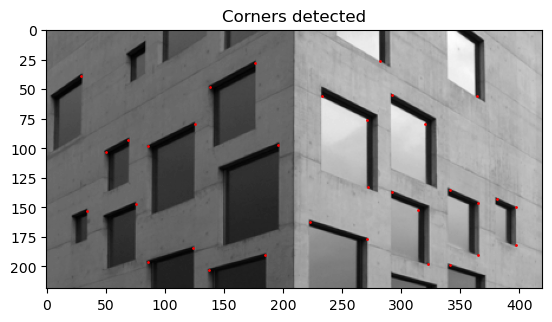

In [1746]:
from skimage.feature import corner_peaks,corner_harris
measure_image = corner_harris(gray)
coords = corner_peaks(measure_image, min_distance=15, threshold_rel=0.02)
display_corners(gray, coords)

In [1747]:
pyramid = gaussian_pyramid(gray)

In [1748]:
import math
rad = []
arr = []
for i,j in coords:
    # normalize LOG
    log_out = LOG(pyramid, i, j)
    # print(log_out)

    # find scale
    max_v = -math.inf
    max_k=1
    for k, val in log_out:
        if val > max_v:
            max_v = val
            max_k = k
    rad.append(k) # todo
    # compute orientation dx,dy
    orient = orientation(i,j,max_k, ix, iy)
    # print(max_k)
    arr.append(orient)


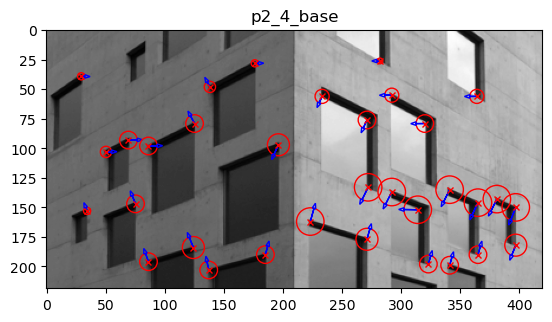

In [1749]:
# plot arrow
arr = np.asarray(arr)
# print(arr[:,1].shape)
# print(arr[:,1])
# show_all_circles(gray, coords[:,1], coords[:,0], rad)
title = "{}_{}".format(name, action)
show_all_arrows(title, gray,coords[:,1], coords[:,0],rad, arr )